In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout

In [ ]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/brain tumor MRI classification','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/brain tumor MRI classification','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:31<00:00,  2.34it/s]


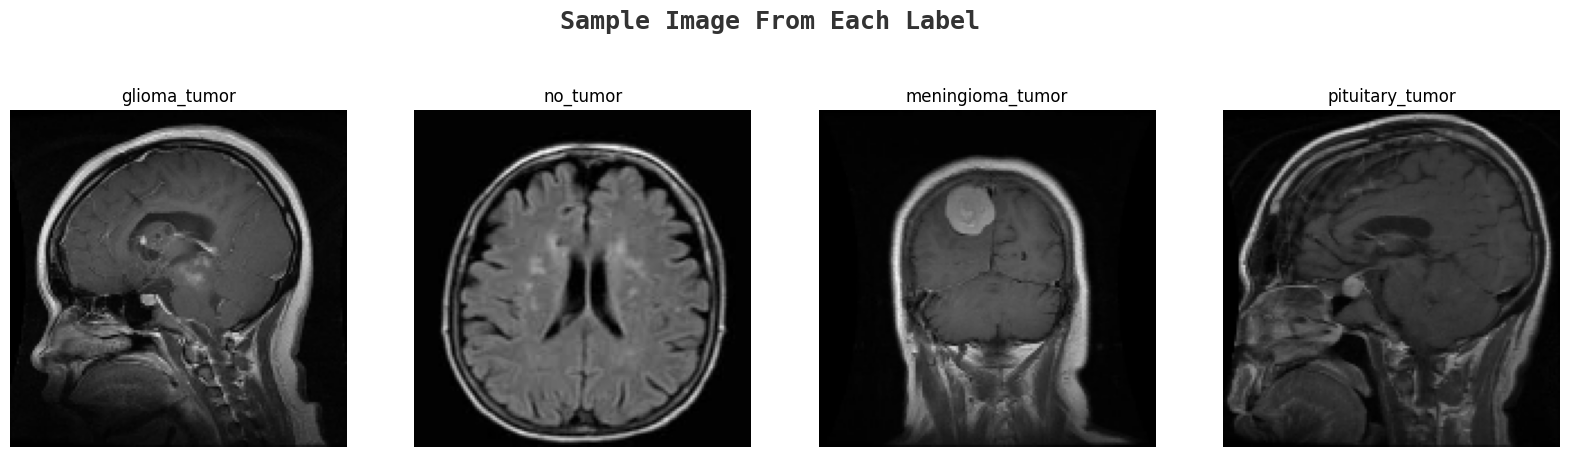

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
X_train.shape

(2937, 150, 150, 3)

In [ ]:
X_test.shape

(327, 150, 150, 3)

In [ ]:
y_train.shape

(2937,)

In [ ]:
y_test.shape

(327,)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)

# Find unique class labels
unique_labels = np.unique(y_test_labels)

print("Unique class labels:", unique_labels)

Unique class labels: [0 1 2 3]


In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.787384 to fit



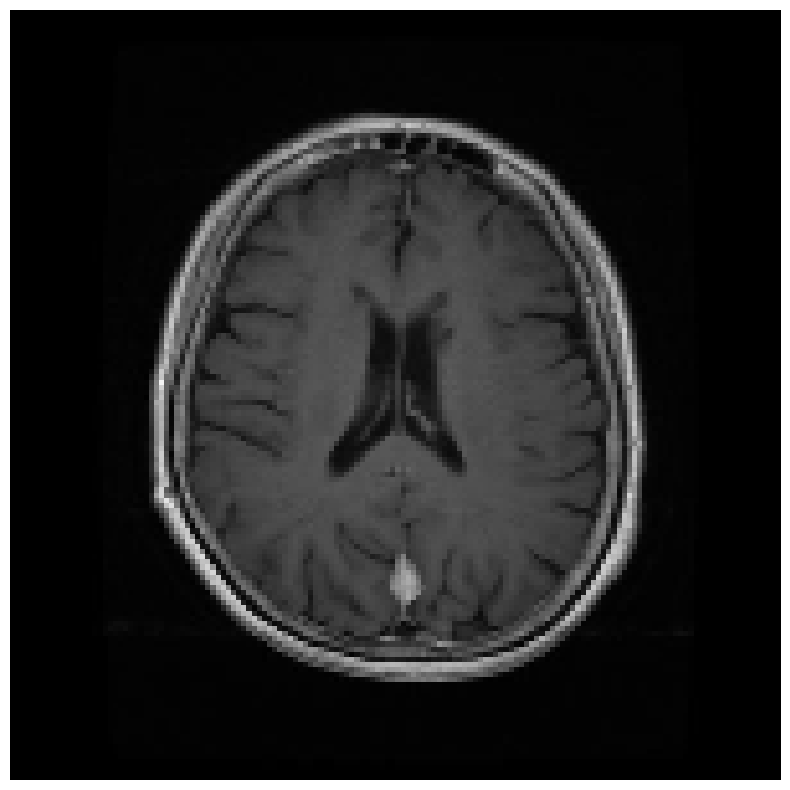

In [ ]:
plot_model(model, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8373
Epoch 1: val_accuracy improved from -inf to 0.89456, saving model to effnet.keras
83/83 [==============================] - 66s 222ms/step - loss: 0.4484 - accuracy: 0.8373 - val_loss: 0.4323 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9379
Epoch 2: val_accuracy did not improve from 0.89456
83/83 [==============================] - 11s 135ms/step - loss: 0.1802 - accuracy: 0.9379 - val_loss: 0.5294 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9599
Epoch 3: val_accuracy improved from 0.89456 to 0.90816, saving model to effnet.keras
83/83 [==============================] - 12s 146ms/step - loss: 0.1236 - accuracy: 0.9599 - val_loss: 0.3925 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 4/5
83/83 [==============================] - ETA: 0s - loss: 0

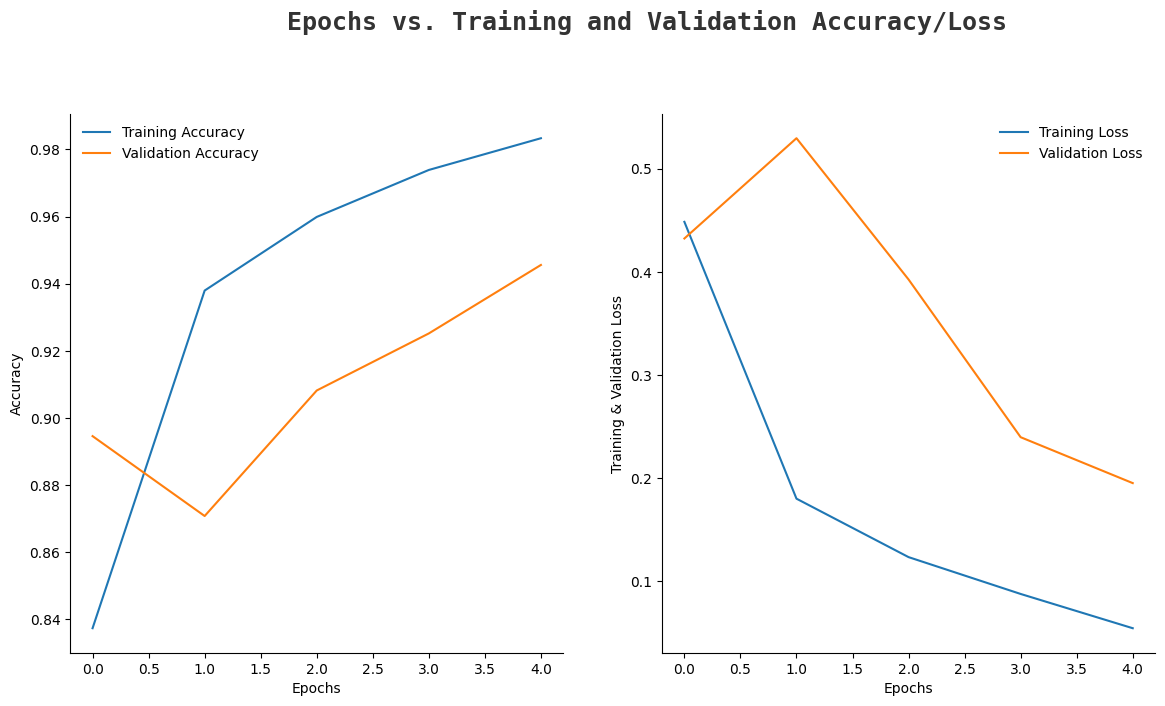

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 3s 121ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        97
           1       0.94      1.00      0.97        48
           2       0.93      0.92      0.93       101
           3       1.00      0.95      0.97        81

    accuracy                           0.95       327
   macro avg       0.95      0.95      0.95       327
weighted avg       0.95      0.95      0.95       327



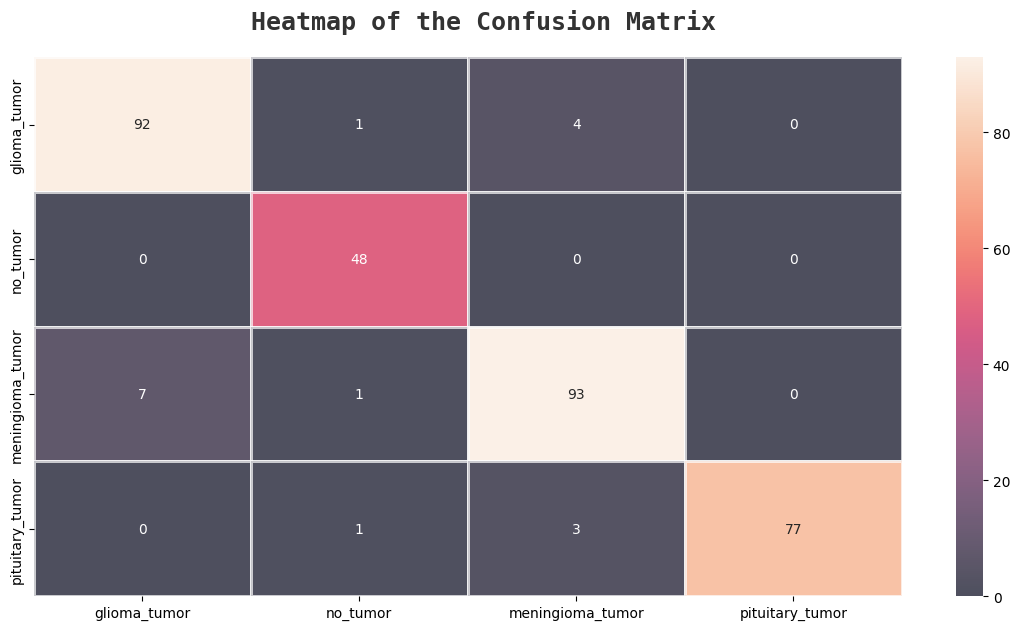

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the VGG-16 model
model_vgg16 = Sequential()

# Block 1
model_vgg16.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model_vgg16.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model_vgg16.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_vgg16.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model_vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model_vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model_vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Dense layers
model_vgg16.add(Flatten())
model_vgg16.add(Dense(4096, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(4096, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(4, activation='softmax'))  # Assuming 4 classes for classification

# Compile the model
model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model_vgg16.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

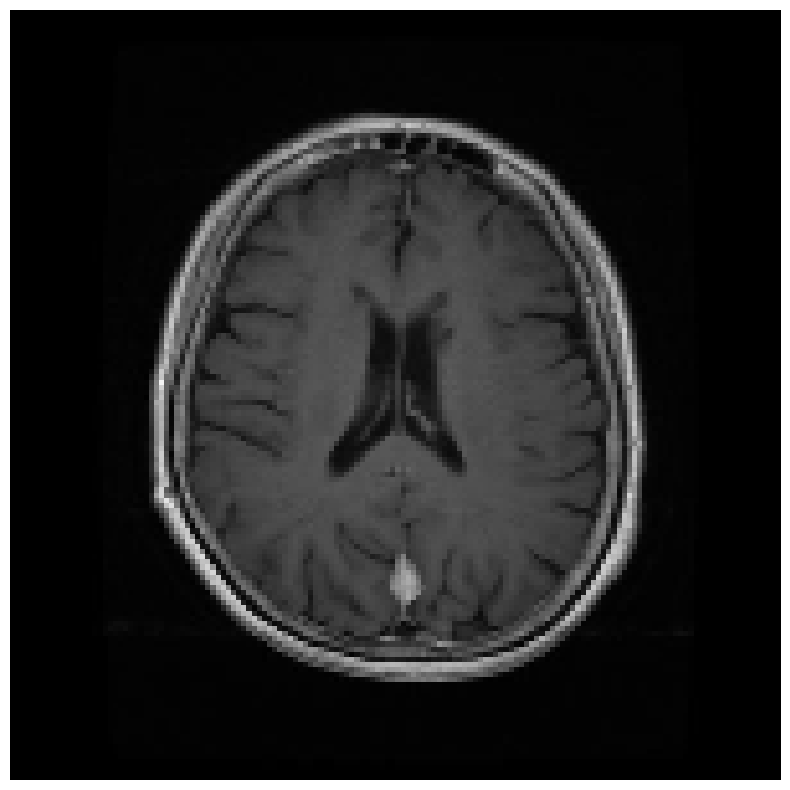

In [ ]:
plot_model(model_vgg16, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
resized_X_train = []
for img in X_train:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_train.append(resized_img)

resized_X_train = np.array(resized_X_train)

resized_X_test = []
for img in X_test:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_test.append(resized_img)

resized_X_test = np.array(resized_X_test)

In [ ]:
model_vgg16.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
history = model_vgg16.fit(resized_X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/10
83/83 [==============================] - ETA: 0s - loss: 6.8800 - accuracy: 0.3243
Epoch 1: val_accuracy did not improve from 0.94558
83/83 [==============================] - 76s 607ms/step - loss: 6.8800 - accuracy: 0.3243 - val_loss: 1.2723 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 2/10
83/83 [==============================] - ETA: 0s - loss: 1.2412 - accuracy: 0.4321
Epoch 2: val_accuracy did not improve from 0.94558
83/83 [==============================] - 34s 412ms/step - loss: 1.2412 - accuracy: 0.4321 - val_loss: 1.1192 - val_accuracy: 0.4864 - lr: 0.0010
Epoch 3/10
83/83 [==============================] - ETA: 0s - loss: 1.0806 - accuracy: 0.5161
Epoch 3: val_accuracy did not improve from 0.94558
83/83 [==============================] - 35s 417ms/step - loss: 1.0806 - accuracy: 0.5161 - val_loss: 0.8617 - val_accuracy: 0.6259 - lr: 0.0010
Epoch 4/10
83/83 [==============================] - ETA: 0s - loss: 0.8484 - accuracy: 0.6440
Epoch 4: val_accuracy did not improv

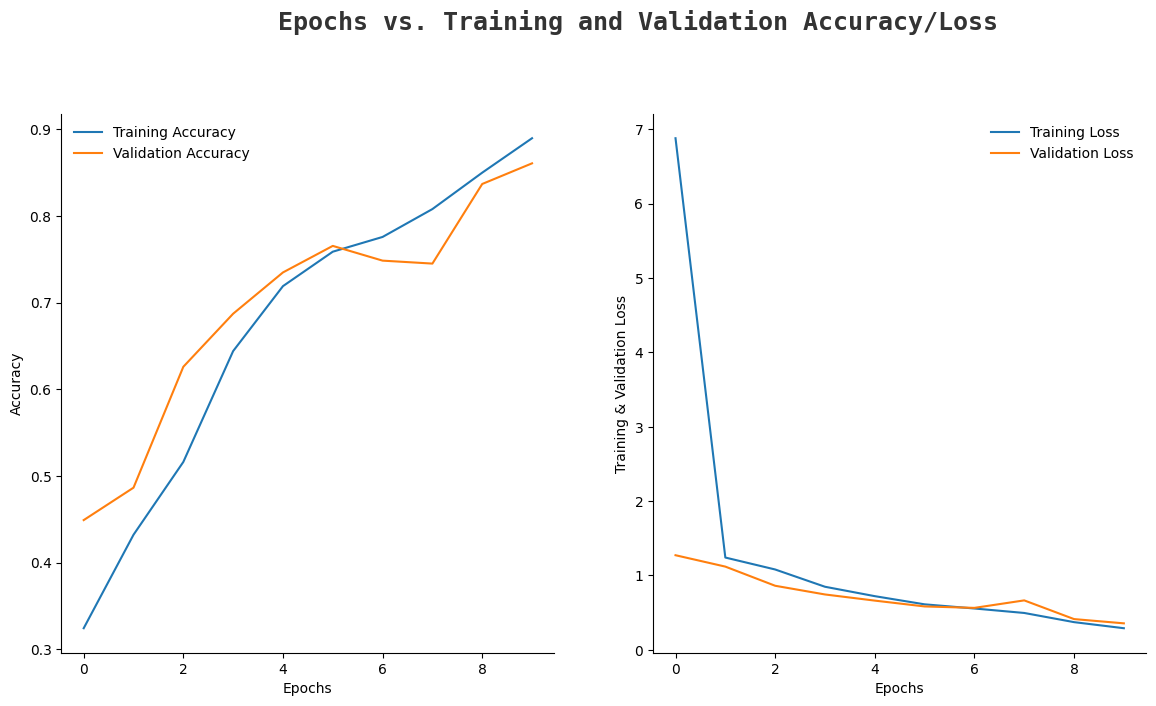

In [ ]:
filterwarnings('ignore')

# Adjust the range to match the number of epochs (10)
epochs = [i for i in range(10)]

fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model_vgg16.predict(resized_X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 3s 313ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        97
           1       0.85      0.92      0.88        48
           2       0.86      0.88      0.87       101
           3       0.93      0.96      0.95        81

    accuracy                           0.89       327
   macro avg       0.88      0.89      0.89       327
weighted avg       0.89      0.89      0.89       327



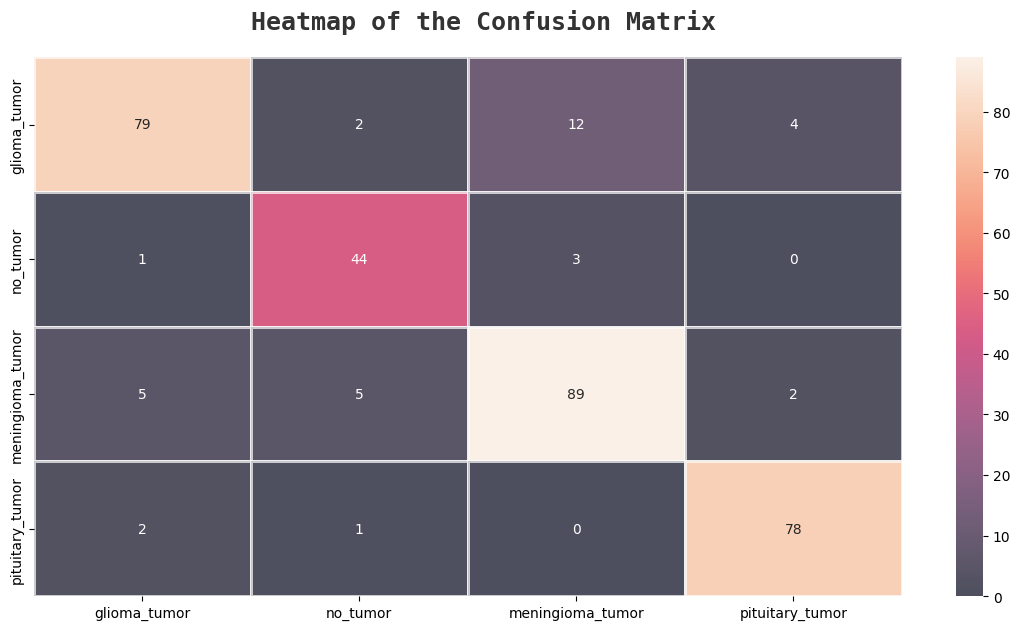

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [ ]:
model.save("/content/drive/MyDrive/BTD_MRI_Model/brain_vgg16.h5")